In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

# Step 1: Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Step 2: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 3: Fit the model to the training data
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Fit the model to the training data
training_set = train_datagen.flow_from_directory('Original_dataset', target_size=(64, 64), batch_size=32, class_mode='binary')
test_set = test_datagen.flow_from_directory('Original_dataset', target_size=(64, 64), batch_size=32, class_mode='binary')

model.fit(training_set, steps_per_epoch=(800*2)//32, epochs=25, validation_data=test_set, validation_steps=(200*2)//32)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/25
50/50 [==============================] - 5s 92ms/step - loss: 0.9823 - accuracy: 0.5404 - val_loss: 0.6198 - val_accuracy: 0.6641
Epoch 2/25
50/50 [==============================] - 4s 86ms/step - loss: 0.6256 - accuracy: 0.6475 - val_loss: 0.6118 - val_accuracy: 0.6484
Epoch 3/25
50/50 [==============================] - 4s 87ms/step - loss: 0.5818 - accuracy: 0.7013 - val_loss: 0.5535 - val_accuracy: 0.7031
Epoch 4/25
50/50 [==============================] - 4s 83ms/step - loss: 0.5640 - accuracy: 0.7044 - val_loss: 0.5742 - val_accuracy: 0.6927
Epoch 5/25
50/50 [==============================] - 4s 83ms/step - loss: 0.5531 - accuracy: 0.7159 - val_loss: 0.5664 - val_accuracy: 0.7214
Epoch 6/25
50/50 [==============================] - 4s 84ms/step - loss: 0.5185 - accuracy: 0.7393 - val_loss: 0.4687 - val_accuracy: 0.7891
Epoch 7/25
50/50 [==============================] - 4s 82ms/step - los

In [4]:
# Step 4: Evaluate the model
scores = model.evaluate(test_set, steps=(200*2)//32)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# Step 5: Use the model to make predictions
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('Original_dataset/waffles/3138.jpg', target_size=(64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

if result[0][0] >= 0.5:
    prediction = 'waffles'
else:
    prediction = 'grilled_cheese'

print('Prediction:', prediction)

12/12 [==============================] - 1s 60ms/step - loss: 0.3798 - accuracy: 0.8229
Test loss: 0.37980547547340393
Test accuracy: 0.8229166865348816
1/1 [==============================] - 0s 63ms/step
Prediction: waffles


In [13]:
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
import os
import numpy as np

# Load and preprocess the images
def load_images(directory, target_size=(64, 64)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_dir, image_name)
                    image = load_img(image_path, target_size=target_size)
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

X, y = load_images('Original_dataset')

# Flatten the images
X = X.reshape((X.shape[0], -1))

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# Apply the JL transform
transformer = GaussianRandomProjection(n_components=128)
X_jl = transformer.fit_transform(X)

# Apply PCA
pca = PCA(n_components=128)
X_pca = pca.fit_transform(X)

# Split the data into a training set and a test set
X_train_jl, X_test_jl, y_train, y_test = train_test_split(X_jl, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.2, random_state=42)

# Train a SVM classifier on the JL-transformed data
clf_jl = SVC()
clf_jl.fit(X_train_jl, y_train)

# Train a SVM classifier on the PCA-transformed data
clf_pca = SVC()
clf_pca.fit(X_train_pca, y_train)

# Evaluate the classifiers
print('Test accuracy (JL):', clf_jl.score(X_test_jl, y_test))
print('Test accuracy (PCA):', clf_pca.score(X_test_pca, y_test))

Test accuracy (JL): 0.6775
Test accuracy (PCA): 0.6925


In [14]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Predict the classes
y_pred_jl = clf_jl.predict(X_test_jl)
y_pred_pca = clf_pca.predict(X_test_pca)

# Print classification reports
print('Classification report (JL):\n', classification_report(y_test, y_pred_jl))
print('Classification report (PCA):\n', classification_report(y_test, y_pred_pca))

# Print confusion matrices
print('Confusion matrix (JL):\n', confusion_matrix(y_test, y_pred_jl))
print('Confusion matrix (PCA):\n', confusion_matrix(y_test, y_pred_pca))

# Compute ROC curve and ROC area for each class
fpr_jl, tpr_jl, _ = roc_curve(y_test, y_pred_jl)
fpr_pca, tpr_pca, _ = roc_curve(y_test, y_pred_pca)
roc_auc_jl = auc(fpr_jl, tpr_jl)
roc_auc_pca = auc(fpr_pca, tpr_pca)

print('AUC (JL):', roc_auc_jl)
print('AUC (PCA):', roc_auc_pca)

Classification report (JL):
               precision    recall  f1-score   support

           0       0.67      0.69      0.68       201
           1       0.68      0.66      0.67       199

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

Classification report (PCA):
               precision    recall  f1-score   support

           0       0.69      0.71      0.70       201
           1       0.70      0.68      0.69       199

    accuracy                           0.69       400
   macro avg       0.69      0.69      0.69       400
weighted avg       0.69      0.69      0.69       400

Confusion matrix (JL):
 [[139  62]
 [ 67 132]]
Confusion matrix (PCA):
 [[142  59]
 [ 64 135]]
AUC (JL): 0.6774294357358935
AUC (PCA): 0.6924298107452687


In [15]:
def preprocess_image(image_path, target_size=(64, 64)):
    # Load and preprocess the image
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image.reshape((1, -1))
    return image

def classify_image(image_path, transformer, classifier):
    # Preprocess the image
    image = preprocess_image(image_path)

    # Apply the transformation
    image_transformed = transformer.transform(image)

    # Predict the class
    prediction = classifier.predict(image_transformed)

    # Decode the prediction
    class_name = le.inverse_transform(prediction)

    return class_name

# Classify a new image
image_path = 'Original_dataset/waffles/3138.jpg'
print('Predicted class (JL):', classify_image(image_path, transformer, clf_jl))
print('Predicted class (PCA):', classify_image(image_path, pca, clf_pca))

Predicted class (JL): ['waffles']
Predicted class (PCA): ['waffles']


In [16]:
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection
import os
import numpy as np

# Load and preprocess the images
def load_images(directory, target_size=(64, 64)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_dir, image_name)
                    image = load_img(image_path, target_size=target_size)
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

X, y = load_images('Original_dataset')

# Flatten the images
X = X.reshape((X.shape[0], -1))

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the original data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a SVM classifier on the original data
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier
print('Test accuracy (Original):', clf.score(X_test, y_test))

# Apply the JL transform
transformer = GaussianRandomProjection(n_components=128)
X_jl = transformer.fit_transform(X)

# Apply PCA
pca = PCA(n_components=128)
X_pca = pca.fit_transform(X)

# Split the data into a training set and a test set
X_train_jl, X_test_jl, y_train, y_test = train_test_split(X_jl, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.2, random_state=42)

# Train a SVM classifier on the JL-transformed data
clf_jl = SVC()
clf_jl.fit(X_train_jl, y_train)

# Train a SVM classifier on the PCA-transformed data
clf_pca = SVC()
clf_pca.fit(X_train_pca, y_train)

# Evaluate the classifiers
print('Test accuracy (JL):', clf_jl.score(X_test_jl, y_test))
print('Test accuracy (PCA):', clf_pca.score(X_test_pca, y_test))

Test accuracy (Original): 0.6975
Test accuracy (JL): 0.66
Test accuracy (PCA): 0.7


In [23]:
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.decomposition import PCA, FactorAnalysis, NMF
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE, Isomap
from umap.umap_ import UMAP
from keras.layers import Input, Dense
from keras.models import Model
import os
import numpy as np

# Load and preprocess the images
def load_images(directory, target_size=(64, 64)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(class_dir, image_name)
                    image = load_img(image_path, target_size=target_size)
                    image = img_to_array(image)
                    images.append(image)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

X, y = load_images('Original_dataset')

# Flatten the images
X = X.reshape((X.shape[0], -1))

# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

# Split the original data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a SVM classifier on the original data
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the classifier
print('Test accuracy (Original):', clf.score(X_test, y_test))

# Apply the JL transform
transformer = GaussianRandomProjection(n_components=128)
X_jl = transformer.fit_transform(X)

# Apply PCA
pca = PCA(n_components=128)
X_pca = pca.fit_transform(X)

# Apply LDA
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

# Apply t-SNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Apply Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X)

# Apply UMAP
umap = UMAP(n_components=2)
X_umap = umap.fit_transform(X)

# Apply Factor Analysis
fa = FactorAnalysis(n_components=2)
X_fa = fa.fit_transform(X)

# Apply NMF
nmf = NMF(n_components=2)
X_nmf = nmf.fit_transform(X)

# Apply Autoencoder
input_img = Input(shape=(X.shape[1],))
encoded = Dense(128, activation='relu')(input_img)
decoded = Dense(X.shape[1], activation='sigmoid')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, validation_data=(X, X))
X_autoencoder = encoder.predict(X)

# Train and evaluate a SVM classifier for each transformation
for name, X_transformed in [('JL', X_jl), ('PCA', X_pca), ('LDA', X_lda), ('t-SNE', X_tsne), ('Isomap', X_isomap), ('UMAP', X_umap), ('Factor Analysis', X_fa), ('NMF', X_nmf), ('Autoencoder', X_autoencoder)]:
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
    clf = SVC()
    clf.fit(X_train, y_train)
    print('Test accuracy ({}):'.format(name), clf.score(X_test, y_test))

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test accuracy (Original): 0.6975
Epoch 1/50
8/8 [==============================] - 1s 74ms/step - loss: -1.0968 - val_loss: -16.0271
Epoch 2/50
8/8 [==============================] - 0s 58ms/step - loss: -28.0868 - val_loss: -45.5301
Epoch 3/50
8/8 [==============================] - 0s 52ms/step - loss: -61.9201 - val_loss: -89.0526
Epoch 4/50
8/8 [==============================] - 0s 52ms/step - loss: -129.0232 - val_loss: -219.7296
Epoch 5/50
8/8 [==============================] - 0s 53ms/step - loss: -423.6067 - val_loss: -913.6765
Epoch 6/50
8/8 [==============================] - 0s 53ms/step - loss: -1965.1194 - val_loss: -4344.4448
Epoch 7/50
8/8 [==============================] - 0s 51ms/step - loss: -8909.4600 - val_loss: -18693.2402
Epoch 8/50
8/8 [==============================] - 0s 50ms/step - loss: -35631.9102 - val_loss: -70188.0938
Epoch 9/50
8/8 [==============================] - 0s 49ms/step - loss: -125225.8906 - val_loss: -233045.1875
Epoch 10/50
8/8 [===============

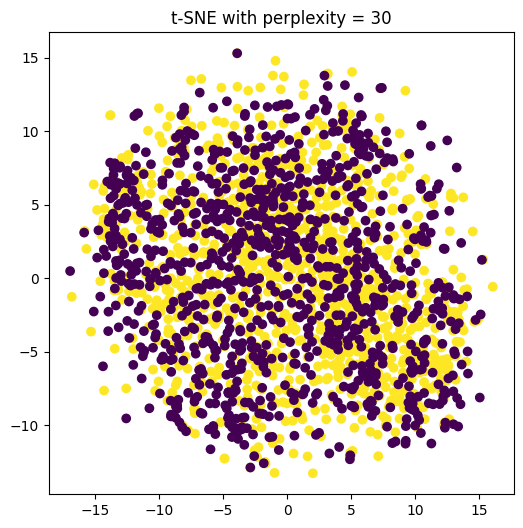

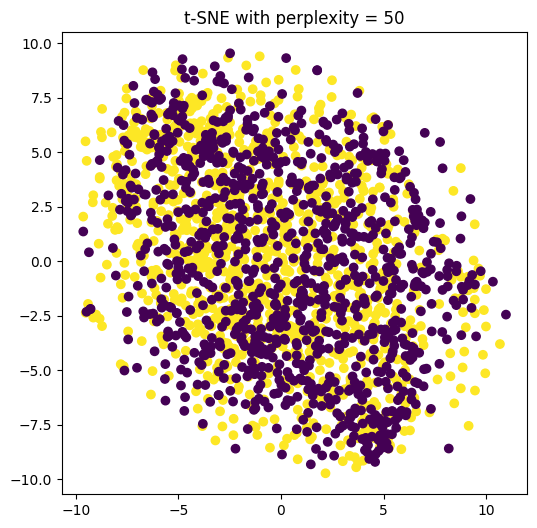

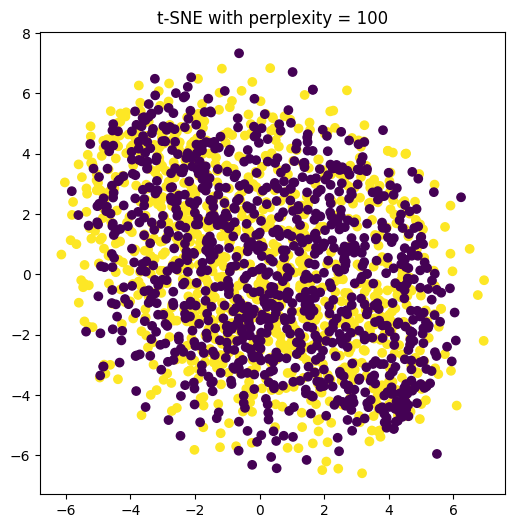

In [26]:
import matplotlib.pyplot as plt

for perplexity in [30, 50, 100]:
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X)
    
    plt.figure(figsize=(6, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
    plt.title(f't-SNE with perplexity = {perplexity}')
    plt.show()

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)

# Define a range of parameters for PCA
pca_params = {'n_components': [64, 128, 256, 512]}

# Perform grid search for PCA
pca_gs = GridSearchCV(PCA(), pca_params)
pca_gs.fit(X_scaled)
best_pca = pca_gs.best_estimator_

# Print the best PCA parameters
print('Best PCA parameters:', pca_gs.best_params_)

# Define a range of parameters for the SVM
svm_params = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'poly', 'sigmoid']}

# Perform grid search for the SVM
svm_gs = GridSearchCV(SVC(), svm_params)
svm_gs.fit(X_train_scaled, y_train)
best_svm = svm_gs.best_estimator_

# Print the best SVM parameters
print('Best SVM parameters:', svm_gs.best_params_)

# Apply t-SNE with perplexity=50
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X_scaled)

# If you want to visualize the result
plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis')
plt.title('t-SNE with perplexity = 50')
plt.show()

ValueError: X has 128 features, but StandardScaler is expecting 12288 features as input.

In [30]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets after scaling
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Now you can use X_train_scaled for the SVM grid search
svm_gs = GridSearchCV(SVC(), svm_params)
svm_gs.fit(X_train_scaled, y_train)
best_svm = svm_gs.best_estimator_

# Print the best SVM parameters
print('Best SVM parameters:', svm_gs.best_params_)

Best SVM parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}


In [31]:
# Create a new SVM model with the best parameters
best_svm_model = SVC(C=0.1, gamma=0.001, kernel='poly')

# Train the model on the scaled training data
best_svm_model.fit(X_train_scaled, y_train)

# Now you can use best_svm_model to make predictions
# For example, to predict the labels of the test data, you can do:
# y_pred = best_svm_model.predict(X_test_scaled)

SVC(C=0.1, gamma=0.001, kernel='poly')